## [Dacon] 태양광 발전량 예측 AI 경진대회
## tacomaster 
## 2021년 2월 1일 

## 1. 라이브러리 및 데이터
## Library & Data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn import ensemble

train = pd.read_csv('data/train/train.csv')
submission = pd.read_csv('data/sample_submission.csv')
submission.set_index('id',inplace=True)

###check shape of train and test set
print("shape of train: ",train.shape)
print("shape of test: ",test.shape)

### null값 여부 dtype 확인
print(train.info())

shape of train:  (52560, 9)
shape of test:  (81, 384)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
Day       52560 non-null int64
Hour      52560 non-null int64
Minute    52560 non-null int64
DHI       52560 non-null int64
DNI       52560 non-null int64
WS        52560 non-null float64
RH        52560 non-null float64
T         52560 non-null int64
TARGET    52560 non-null float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB
None


## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

In [26]:
def preprocess(dataset, target, start_index, end_index, history_size,
                      target_size, step):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index, 48):
        indices = range(i-history_size, i, step)
        data.append(np.ravel(dataset[indices].T))
        labels.append(target[i:i+target_size])
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# x_col =['DHI','DNI','WS','RH','T','TARGET']
x_col =['DHI','RH','T','TARGET']
y_col = ['TARGET']

dataset = train.loc[:,x_col].values
label = np.ravel(train.loc[:,y_col].values)

past_history = 48 * 2
future_target = 48 * 2

### transform train
train_data, train_label = preprocess(dataset, label, 0,None, past_history,future_target, 1)
### transform test
test = []
for i in range(81):
    data = []
    tmp = pd.read_csv(f'data/test/{i}.csv')
    tmp = tmp.loc[:, x_col].values
    tmp = tmp[-past_history:,:]
    data.append(np.ravel(tmp.T))
    data = np.array(data)
    test.append(data)
test = np.concatenate(test, axis=0)

###check shape of train and test set

        


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
Day       52560 non-null int64
Hour      52560 non-null int64
Minute    52560 non-null int64
DHI       52560 non-null int64
DNI       52560 non-null int64
WS        52560 non-null float64
RH        52560 non-null float64
T         52560 non-null int64
TARGET    52560 non-null float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


## 3. 탐색적 자료분석
## Exploratory Data Analysis


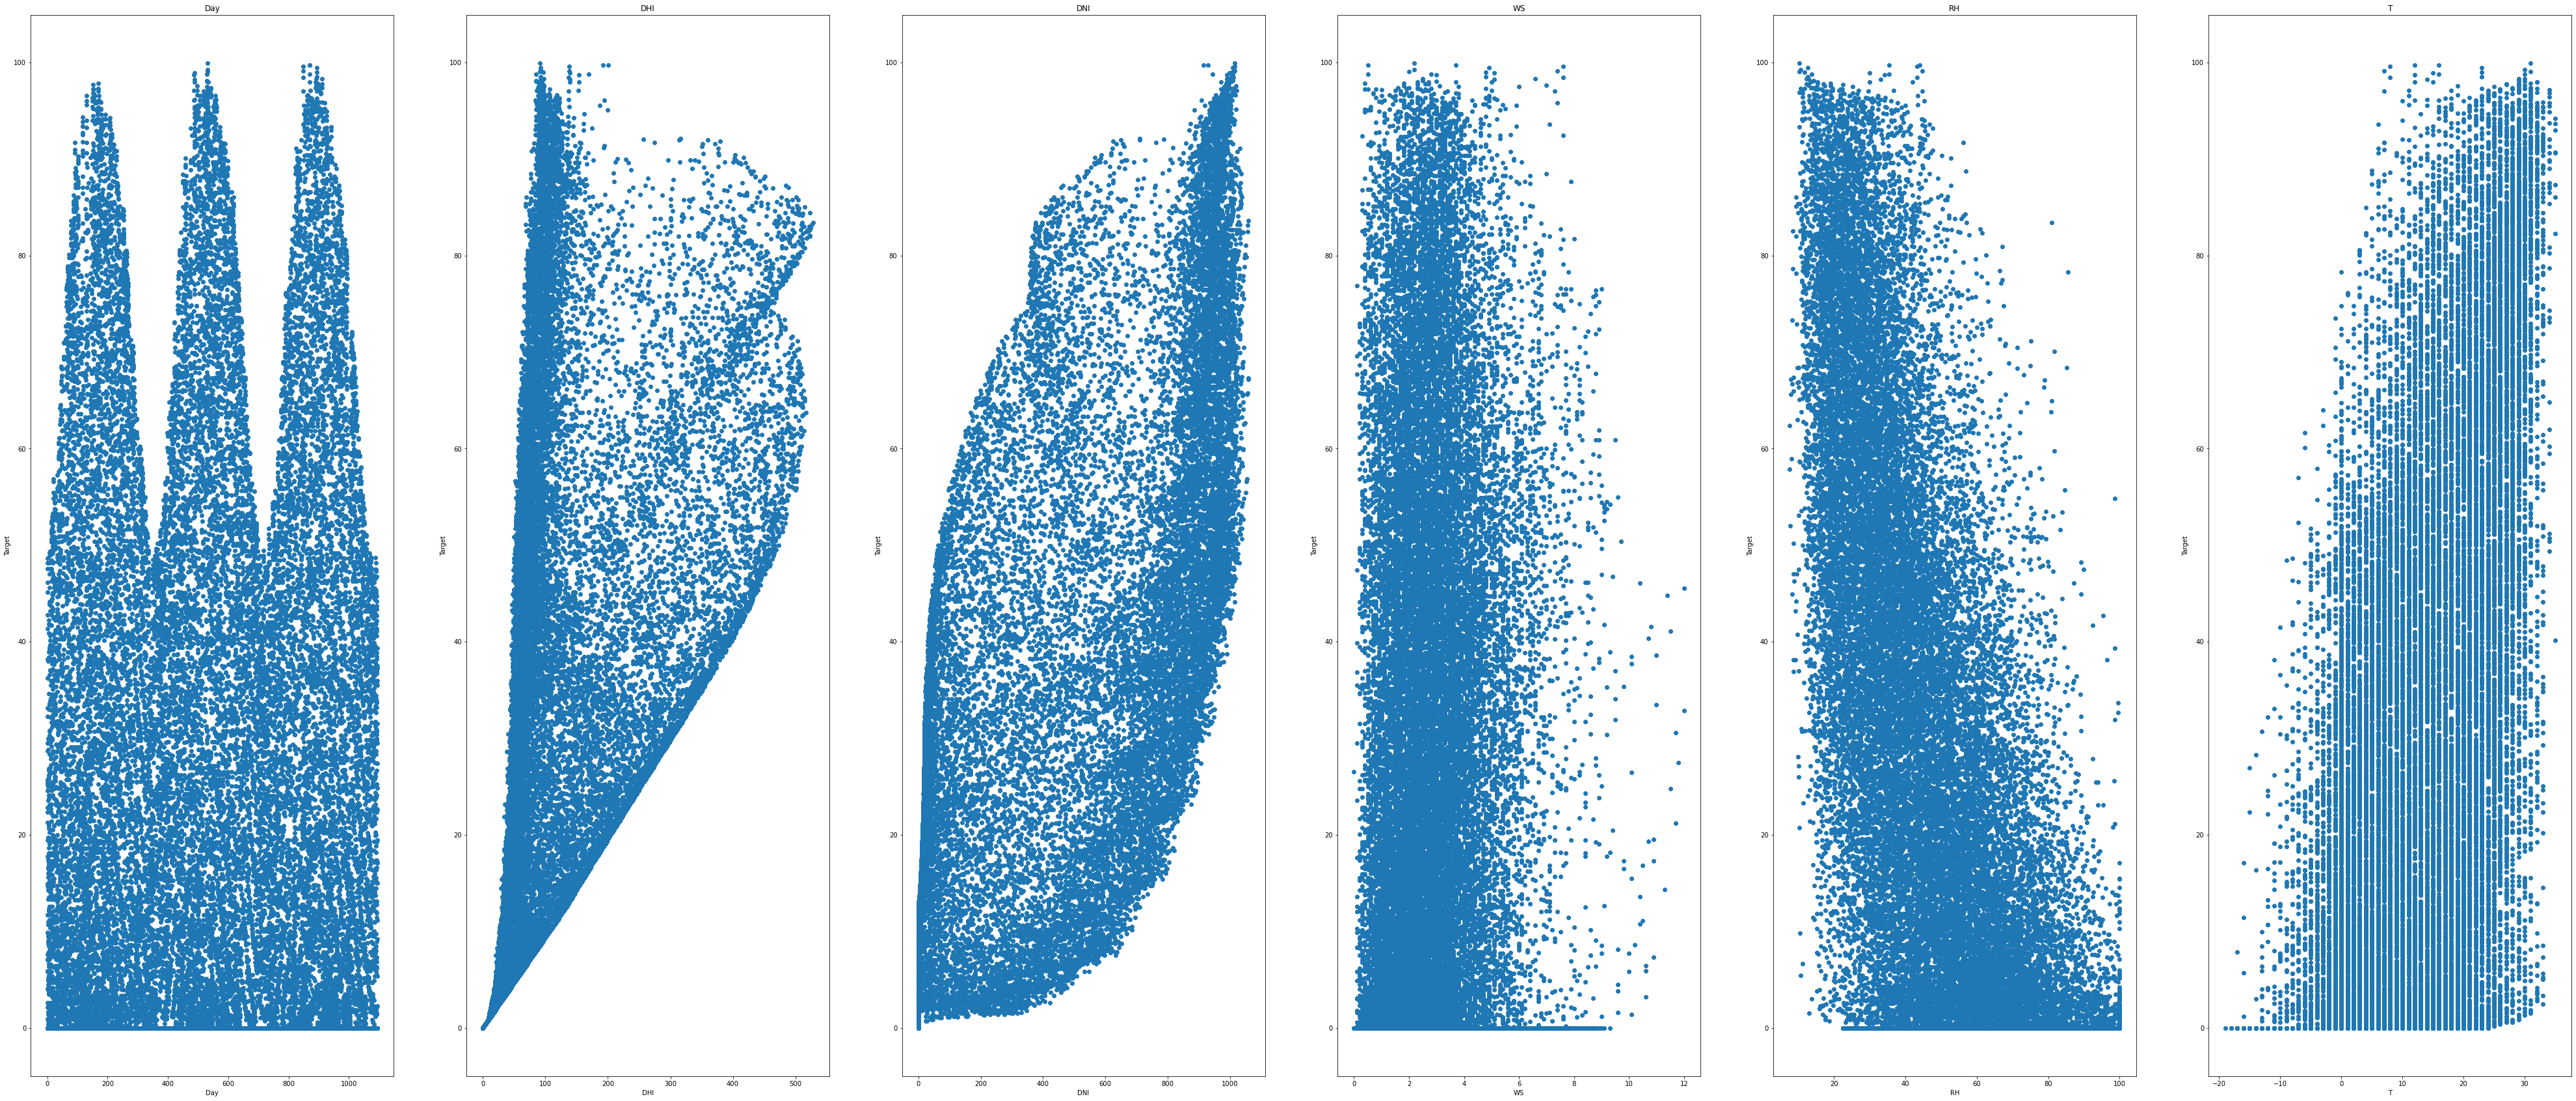

In [3]:
### 각 항목과 target사이의 상관관계 도출
plt.figure(figsize = (70,30))

feature = ['Day','DHI', 'DNI', 'WS', 'RH', 'T']

for i, col in enumerate(feature):
    plt.subplot(1,len(feature), i+1)
    x = train[col]
    y = train['TARGET']
    plt.scatter(x,y,marker = 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Target')
plt.show()

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [4]:
N_ESTIMATORS = 1300
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS,
                                    max_features=5, random_state=0,
                                    max_depth = 20,
                                    verbose=True,
                                    n_jobs=-1)
rf.fit(train_data, train_label)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1300 out of 1300 | elapsed:    2.7s finished


## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

In [5]:
rf_preds = []
for estimator in rf.estimators_:
    rf_preds.append(estimator.predict(test))
rf_preds = np.array(rf_preds)

for i, q in enumerate(np.arange(0.1, 1, 0.1)):
    y_pred = np.percentile(rf_preds, q * 100, axis=0)
    submission.iloc[:, i] = np.ravel(y_pred)

## 6. 결과 및 결언
## Conclusion & Discussion

In [ ]:
submission.to_csv(f'submission.csv')